In [1]:
# Standard lib imports
from typing import Union, Tuple, Callable, Any

# Third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
DATA_PATH = '../data/telco.csv'

In [3]:
df_churn = pd.read_csv(DATA_PATH)
df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
def string_transformations(
    target: Union[pd.core.strings.accessor.StringMethods, pd.core.indexes.base.Index]
) -> Union[pd.core.series.Series, pd.core.indexes.base.Index]:
    """
        Stage 1 cleaning for this churn prediction:
        - Lower case for everything
        - Spaces replaced by underscores

        Can work on either Pandas indices (e.g. column headers) or Pandas series (e.g. row data)
        
        :param StringMethods | Index target: the target row or column to standardise
        :return StringMethods | Index result: the standardised row or column

        Note the return types are using typing since this was written pre-3.10.
    """
    result = (
        target
        .str
        .lower()
        .str
        .replace(' ', '_')
    )

    return result

In [5]:
# Fix lack of consistency in columns
def standardise_strings(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()
    df_new.columns = string_transformations(target=df_new.columns)

    object_filter = df_new.dtypes == type(object)

    categorical_columns = list(df_new.dtypes[object_filter].index)
    df_new[categorical_columns] = df_new[categorical_columns].apply(func=string_transformations, axis=1)
    return df_new

def standardise_float(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    new_col = pd.to_numeric(df[col_name], errors='coerce')

    df_new = df.copy()
    df_new[col_name] = new_col.fillna(0)

    return df_new

def encode_labels(df: pd.DataFrame, col_name: str, encode_value: str) -> pd.DataFrame:
    new_col = (df[col_name] == encode_value).astype(int)

    df_new = df.copy()
    df_new[col_name] = new_col

    return df_new

In [6]:
df_churn_standardised = standardise_strings(df_churn)
df_fixed_charges = standardise_float(df=df_churn_standardised, col_name='totalcharges')
df_encoded_labels = encode_labels(df=df_fixed_charges, col_name='churn', encode_value='yes')

In [7]:
# Using scikit-learn - no need to write this custom anymore like in the other follow-along!
df_full_train, df_test = train_test_split(df_encoded_labels, test_size=0.2, random_state=1)

# But this splits into just train (80%) and test (20%). This needs another split for validation component.
# To split the training set again and end up with train (60%), validation (20%), test (20%)
# This requires a split of (.20/.80) = 0.25
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Val and test should be same length
print(f"{len(df_train)=}")
print(f"{len(df_val)=}")
print(f"{len(df_test)=}")

len(df_train)=4225
len(df_val)=1409
len(df_test)=1409


In [8]:
# Time to set up these dataframes for testing/training/validation
# Sort them and separate out the desired label (churn)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['churn'].values
y_val = df_val['churn'].values
y_test = df_test['churn'].values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [9]:
numeric_variables = ['tenure', 'monthlycharges', 'totalcharges']
categorical_variables = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [22]:
def train_model(df: pd.DataFrame, categorical_variables: list[str], numeric_variables: list[str], y_train: pd.Series) -> Tuple[LogisticRegression, DictVectorizer]:
    dict_df = df[categorical_variables + numeric_variables].to_dict(orient="records")
    vectorizer = DictVectorizer(sparse=False)
    X_train = vectorizer.fit_transform(dict_df)
    print(f"{X_train.shape=}")

    model = LogisticRegression()
    model.fit(X_train, y_train)

    return model, vectorizer

In [11]:
# # Skipped ahead to the training/use of this model - no need for all the EDA in previous notebook
# # Maybe turn this into a function to get the "final" model
# dict_full_train = df_full_train[categorical_variables + numeric_variables].to_dict(orient="records")
# full_vectorizer = DictVectorizer(sparse=False)
# X_full_train = full_vectorizer.fit_transform(dict_full_train)
# y_full_train = df_full_train.churn.values

# final_model = LogisticRegression()
# final_model.fit(X_full_train, y_full_train)

# dicts_test = df_test[categorical_variables + numeric_variables].to_dict(orient="records")
# X_test = full_vectorizer.transform(dicts_test)

# y_test_pred = final_model.predict_proba(X_test)[:, 1]
# churn_decision = (y_test_pred > 0.5)

# (churn_decision == y_test).mean()

In [23]:
model, full_vectorizer = train_model(df=df_train, categorical_variables=categorical_variables, numeric_variables=numeric_variables, y_train=y_train)

dict_val = df_val[categorical_variables + numeric_variables].to_dict(orient="records")
dict_test = df_test[categorical_variables + numeric_variables].to_dict(orient="records")
X_val = full_vectorizer.transform(dict_val)
X_test = full_vectorizer.transform(dict_test)
y_val_pred = model.predict_proba(X_val)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]
churn_decision = (y_val_pred > 0.5)
(y_val == churn_decision).mean()

X_train.shape=(4225, 45)


0.8034066713981547

#### Evaluating Model Accuracy

[0.2739531582682754, 0.5088715400993612, 0.5911994322214337, 0.6664300922640171, 0.7097232079489, 0.7388218594748048, 0.7601135557132718, 0.7721788502484032, 0.7849538679914834, 0.7934705464868701, 0.8034066713981547, 0.801277501774308, 0.794889992902768, 0.7863733144073811, 0.765791341376863, 0.7444996451383961, 0.7345635202271115, 0.7260468417317246, 0.7260468417317246, 0.7260468417317246, 0.7260468417317246]


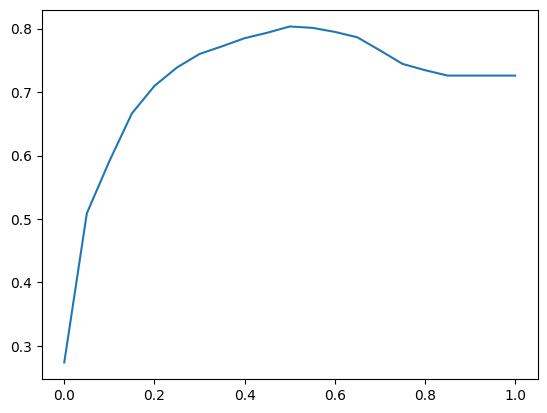

In [24]:
thresholds = np.linspace(0, 1, 21)
test = thresholds[0]

def check_threshold(y_val: np.ndarray, y_pred: np.ndarray, threshold: float):
    return accuracy_score(y_val, y_pred >= threshold)

threshold_scores = [check_threshold(y_val=y_val, y_pred=y_val_pred, threshold=threshold) for threshold in thresholds]
print(threshold_scores)
plt.plot(thresholds, threshold_scores)

In [25]:
# So it turns out 0.5 was the right churn decision threshold to pick.
# Also turns out (y_pred == churn_decision).mean() has a built-in sklearn equivalent
accuracy_score(y_val, y_val_pred >= 0.5)

0.8034066713981547

In [26]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

threshold = 0.5
predict_positive = (y_val_pred >= threshold)
predict_negative = (y_val_pred < threshold)

In [28]:
results_true_positive = (predict_positive & actual_positive).sum()
results_true_negative = (predict_negative & actual_negative).sum()
results_false_positive = (predict_positive & actual_negative).sum()
results_false_negative = (predict_negative & actual_positive).sum()

results_true_positive, results_true_negative, results_false_negative, results_false_positive

(210, 922, 176, 101)

In [29]:
confusion_matrix = np.array([
    [results_true_negative, results_false_positive],
    [results_false_negative, results_true_positive]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [30]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])